<a href="https://colab.research.google.com/github/jbonifo/Kaggle_Project/blob/main/Retail_products_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Libraries

In [15]:
! pip install pandas

In [16]:
! pip install sklearn

In [17]:
! pip install opencv-python

In [18]:
#Have to reinstall kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle

Processing /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303/kaggle-1.5.12-cp37-none-any.whl
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


# Import Libraries

In [19]:
#import libraries that we need

import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import os #work with files from the system
import cv2 #work with pictures (comes from OpenCV)
from google.colab.patches import cv2_imshow #to display picture
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import nltk # used for preprocessing text 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords # used for preprocessing
from nltk.stem import WordNetLemmatizer # used for preprocessing
import re # used for preprocessing
import string # used for preprocessing
from sklearn.preprocessing import LabelEncoder
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Import Data

We import the dataset directly from Kaggle

In [20]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jbonifo1","key":"564664edd4aa7dc9269dbcbf23c08c56"}'}

In [21]:
#Make directory named kaggle and copy kaggle.json file there.
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [22]:
#Change the permissions of the file.
! chmod 600 ~/.kaggle/kaggle.json

In [23]:
#We create a new folder
! mkdir -p Kaggle_project

In [24]:
#We check if all operations before had succeed
! kaggle datasets list

ref                                                           title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
gpreda/reddit-vaccine-myths                                   Reddit Vaccine Myths                              232KB  2021-06-30 11:37:00           8589        731  1.0              
crowww/a-large-scale-fish-dataset                             A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           5246        413  0.9375           
imsparsh/musicnet-dataset                                     MusicNet Dataset                                   22GB  2021-02-18 14:12:19           1837        146  1.0              
promptcloud/careerbuilder-job-listing-2020                    Careerbuilder Job 

In [25]:
#We download the dataset directly from Kaggle into the new folder
! kaggle competitions download -c retail-products-classification -p /content/Kaggle_project/

 94% 244M/259M [00:03<00:00, 67.6MB/s]
100% 259M/259M [00:04<00:00, 67.8MB/s]


In [26]:
#We unwrap the dataset
!unzip /content/Kaggle_project/retail-products-classification.zip -d /content/Kaggle_project/

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /content/Kaggle_project/train/train/B001E6DLOQ.jpg  
  inflating: /content/Kaggle_project/train/train/B001E6DM54.jpg  
  inflating: /content/Kaggle_project/train/train/B001E6DMHW.jpg  
  inflating: /content/Kaggle_project/train/train/B001E6FNQU.jpg  
  inflating: /content/Kaggle_project/train/train/B001E6HVHO.jpg  
  inflating: /content/Kaggle_project/train/train/B001E6HVOC.jpg  
  inflating: /content/Kaggle_project/train/train/B001E6JCR6.jpg  
  inflating: /content/Kaggle_project/train/train/B001E6LAH6.jpg  
  inflating: /content/Kaggle_project/train/train/B001E6LAK8.jpg  
  inflating: /content/Kaggle_project/train/train/B001E6LAUS.jpg  
  inflating: /content/Kaggle_project/train/train/B001E6OCC6.jpg  
  inflating: /content/Kaggle_project/train/train/B001E6TXCU.jpg  
  inflating: /content/Kaggle_project/train/train/B001E6UUT0.jpg  
  inflating: /content/Kaggle_project/train/train/B001E729CK.jpg 

# Prepararation of Data

Preparation of data

1. We create a dict for the categories corresponding to the indexes given on the contest site 
2. We clean the data image set to create an Numpy array
3. We clean the data text set taking just the necessary text (Wuthout Punctuations, Lowcase ...)

In [27]:
# We create a Dict with categories
categories_dic = {"categories":{"Electronics":0,"Sports & Outdoors":1, "Cell Phones & Accessories":2,"Automotive":3,"Toys & Games":4,"Tools & Home Improvement":5,"Health & Personal Care":6,"Beauty":7,"Grocery & Gourmet Food":8,"Office Products":9,"Arts, Crafts & Sewing":10,"Pet Supplies":11,"Patio, Lawn & Garden":12,"Clothing, Shoes & Jewelry":13,"Baby":14,"Musical Instruments":15,"Industrial & Scientific":16,"Baby Products":17,"Appliances":18,"All Beauty":19,"All Electronics":20}}

In [28]:
# We look how the set of datas description is
df = pd.read_csv("/content/Kaggle_project/train.csv")
df.head()

,ImgId,title,description,categories
0,B000HYL1V6,TUNGSTEN SOLDER PICK WITH HANDLE,Solder Pick for picking up molten solder when ...,"Arts, Crafts & Sewing"
1,B00006HXWY,Write Right 98167 Screen Protector for Sony T615C,We all screen. And we all need to protect thos...,Cell Phones & Accessories
2,B000GAWSBS,Casio Mens DBC310-1 Databank 300 Digital Watch...,"Bringing you precision at a glance, the Casio ...","Clothing, Shoes & Jewelry"
3,B000040JOL,Factory-Reconditioned DEWALT DW260KR Heavy-Dut...,Factory-Reconditioned DEWALT DW260KR Heavy-Dut...,Tools & Home Improvement
4,B00006IB78,Energizer 2 in 1 Light,This twoway light features a bright flashlight...,Health & Personal Care


We check if there are any "NaN" in the column "description" to see if there are any description which don't correspond to an image

In [29]:
df['description'].isnull().values.any()
df['description'].isnull().sum()

1042

We remove these NaN from this column

In [30]:
df.dropna(subset = ["description"], inplace=True)
df

,ImgId,title,description,categories
0,B000HYL1V6,TUNGSTEN SOLDER PICK WITH HANDLE,Solder Pick for picking up molten solder when ...,"Arts, Crafts & Sewing"
1,B00006HXWY,Write Right 98167 Screen Protector for Sony T615C,We all screen. And we all need to protect thos...,Cell Phones & Accessories
2,B000GAWSBS,Casio Mens DBC310-1 Databank 300 Digital Watch...,"Bringing you precision at a glance, the Casio ...","Clothing, Shoes & Jewelry"
3,B000040JOL,Factory-Reconditioned DEWALT DW260KR Heavy-Dut...,Factory-Reconditioned DEWALT DW260KR Heavy-Dut...,Tools & Home Improvement
4,B00006IB78,Energizer 2 in 1 Light,This twoway light features a bright flashlight...,Health & Personal Care
...,...,...,...,...
46224,B0000AV1J7,"Berkley Trilene XL 1000 - yard Fishing Line, C...",Smooth - casting Berkley Trilene XL Fishing Li...,Sports & Outdoors
46225,B0006MZPLG,Badger Air-Brush Company Basic Spray Gun Set,"An easy to use, top quality spray gun for the ...","Arts, Crafts & Sewing"
46226,B000GBO8SS,Fimo Soft Polymer Clay 2 Ounces-8020-53 Tropic...,Fimo Soft Polymer Clay is easier to use than b...,"Arts, Crafts & Sewing"
46227,B0000VMA16,Wilton Icing Colors 1 Oz: Rose Petal,Icing Colors. This plastic bottle contains 1 o...,Grocery & Gourmet Food


We can also check if the column "title" contains NAN and remove these NAN

In [31]:
df['title'].isnull().values.any()
df['title'].isnull().sum()

0

We create a list of pictures which there are no descriptions


In [32]:
img_folder = "/content/Kaggle_project/train/train"

In [33]:
# We create a list with all images that they don't have any descriptions and a list with their names
img_data_array=[]
listOfNameData=[]

for file in os.listdir(img_folder):
  gugu = file[:-4] # We remove ".jpg" characters
  if gugu in df['ImgId'].values:

    listOfNameData.append(gugu)
    image_path= os.path.join(img_folder,file)
    image = tf.keras.preprocessing.image.load_img(image_path)#type 'Pile'
    
    img_data_array.append(image)

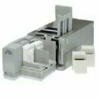

In [34]:
# We print a random image
img_data_array[567]

In [35]:
# listOfNameData=[]

# for file in os.listdir(img_folder):
#   gugu = file[:-4] 
#   if gugu in df['ImgId'].values:
#     listOfNameData.append(gugu)

In [36]:
listOfNameData[78] 

'B00029JLCM'

In [37]:
len(img_data_array)

41051

We create an Numpy array of images to work with the future model


In [38]:
count6=0
for i in img_data_array:
  i = tf.keras.preprocessing.image.img_to_array(i)
  img_data_array[count6]=i
  count6+=1

In [39]:
# The np.array of images is created
img_data_array = np.asarray(img_data_array)

We remove data that they don't have pictures files in the list of images in the train set 

In [40]:
listOfIndexToKeep = []
index = df.index

for i in range(len(listOfNameData)):
    condition = df['ImgId'] == listOfNameData[i]
    apples_indices = index[condition]
    apples_indices_list = apples_indices.tolist()
    listOfIndexToKeep.extend(apples_indices_list)
print(len(listOfIndexToKeep))

41051


In [41]:
#listOfIndexToKeep

In [42]:
# We take only the dataFrame with specify index 
df.loc[listOfIndexToKeep]
dfClean_without_categoriesIndex = df.loc[listOfIndexToKeep]

In [43]:
# We transform the categories column with the Index correspondingly
dfClean = dfClean_without_categoriesIndex.replace(categories_dic)

In [44]:
# We check if the column "categories" has Index
dfClean.head()

# We reorganize the index : 
dfClean.reset_index()

,index,ImgId,title,description,categories
0,29193,B00067AFSO,Basic Comfort Sweet Pea 4 Piece Bedding Set,This 4-piece bedding set from Basic Comfort is...,14
1,2424,B000BO9CQI,Trimaco Builder'S Paper,35140 Features: -Economical craft.-Easy to han...,10
2,8102,B00013MU54,"Grace Frame 3-Z44 Professional No Baste, Fabri...",The Z44 is our top of the line hand quilting f...,10
3,22577,B001GMZ7BS,1 Gallon Stogies Large Cigar Humidor Solution ...,Humidor Solution PG Propylene Glycol Pre-mixed...,18
4,22716,B000BPPRPW,Adaptec 2169300-R 2420SA 4 Channel SATA II RAI...,"Serial ATA II (SATA II), the successor to SATA...",20
...,...,...,...,...,...
41046,3791,9985539052,HTC EVO 4G Professional Blue LED Car Charger f...,LG P990 Phone Professional Blue LED Car Charge...,2
41047,9870,B000F7AMWE,"Southworth Gold Parchment Certificates, Gold a...",Southworth Custom Print Bordered Certificates ...,10
41048,36093,B0000D9MZZ,German Baby Beets (12 ounce),"A delicious accompaniment to other foods, baby...",8
41049,20574,B00000JRH0,Barbie Doll Case,"New design for 2006! Store your Barbie dolls,...",4


We splint the train set in Validation set and Train set

In [45]:
# We build the train data and the Validation data for processing images
X_train_images, X_val_images, y_train_images, y_val_images = train_test_split(img_data_array, dfClean['categories'], test_size=0.2,random_state=1)

In [46]:
# We delete the previous big array to release the RAM
del img_data_array

We clean the text for text preprocessing

In [47]:
# We assemble the titel column with the Descritpion Column
dfClean['description'] = dfClean['title'] + " " + dfClean['description']

# We remove the title descriptio,n
dfClean = dfClean.drop(['title'],axis=1)

# We split in Validation data and train data
X_train_text, X_val_text, y_train_text, y_val_text = train_test_split(dfClean, dfClean['categories'], test_size=0.2,random_state=1)

# We removes the desciption colomn for X_train and X_val
X_train_text = X_train_text.drop(['categories','ImgId'],axis=1)
X_val_text = X_val_text.drop(['categories','ImgId'],axis=1)

In [48]:
X_train_text = X_train_text.reset_index(drop = True)
X_val_text = X_val_text.reset_index(drop = True)
y_train_text = y_train_text.reset_index(drop = True)
y_val_text = y_val_text.reset_index(drop = True)

In [49]:
y_train_text

0        14
1        16
2        19
3         7
4         4
         ..
32835    12
32836     9
32837    10
32838    12
32839    19
Name: categories, Length: 32840, dtype: int64

In [50]:
X_train_text

,description
0,Aqua Leisure Spray and Slide Family Pool Every...
1,6-32 X 1/4 FLAT M/S-PHIL Box Qty. / 100 6-32 X...
2,Bare Escentuals bareMinerals get started eyes ...
3,St. Ives Whipped Silk Intense Body Moisturizer...
4,Construction Wooden Jigsaw Puzzle 48pc This 48...
...,...
32835,"Earthquake EXT12 Earth Auger Extension, 12-Inc..."
32836,Burlington Address Labels Clear Ink Jet/Laser ...
32837,Colorflex Soccer Zipper Pull SportsForHer.com ...
32838,Weber 9869 Stainless Steel Replacement Cooking...


In [51]:
max_words = 2000
tokenize = keras.preprocessing.text.Tokenizer(num_words=max_words)

In [52]:
# We convert the column dataframe of X_train_test and X_val_test into a list
#X_train_test_list = X_train_text.values.tolist()
#X_val_test_list = X_val_text.values.tolist()

In [53]:
#type(X_train_test_list)

In [54]:
X_train_text

,description
0,Aqua Leisure Spray and Slide Family Pool Every...
1,6-32 X 1/4 FLAT M/S-PHIL Box Qty. / 100 6-32 X...
2,Bare Escentuals bareMinerals get started eyes ...
3,St. Ives Whipped Silk Intense Body Moisturizer...
4,Construction Wooden Jigsaw Puzzle 48pc This 48...
...,...
32835,"Earthquake EXT12 Earth Auger Extension, 12-Inc..."
32836,Burlington Address Labels Clear Ink Jet/Laser ...
32837,Colorflex Soccer Zipper Pull SportsForHer.com ...
32838,Weber 9869 Stainless Steel Replacement Cooking...


In [55]:
tokenize.fit_on_texts(X_train_text['description'].astype(str)) # fit tokenizer to our training text data
x_train_text = tokenize.texts_to_matrix(X_train_text['description'].astype(str))
x_val_text = tokenize.texts_to_matrix(X_val_text['description'].astype(str))

In [56]:
x_train_text[32839]

array([0., 0., 1., ..., 0., 0., 0.])

Exemple of Preprocessing Text : https://www.kaggle.com/yufengdev/bbc-text-categorization

# Building Model for images

For images, we use the Keras image classification Model : MobileNet

In [75]:
i = tf.keras.layers.Input([100, 100, 3])
x = tf.keras.applications.mobilenet.preprocess_input(i)
x = tf.keras.applications.MobileNet(input_tensor=i, weights = None ,classes=500)(x)

#x = tf.keras.layers.Flatten()(x)
#x = tf.keras.layers.Dense(21)(x)
# input_tensor = Input(shape=(100,100,3))
# model = MobileNet(input_tensor=input_tensor, include_top=False, weights=None, classes=21)(preprocess)
model1 = tf.keras.Model(inputs=[i], outputs=[x])

In [58]:
array_y_train_images = y_train_images.to_numpy()
array_y_val_images = y_val_images.to_numpy()

In [59]:
# We encode the y train image
onehot_encoder = OneHotEncoder(sparse=False)
y = array_y_train_images
y = y.reshape(len(y), 1)
y_train_im = onehot_encoder.fit_transform(y)
print(y_train_im)

# We encode the y val images
onehot_encoder = OneHotEncoder(sparse=False)
y = array_y_val_images
y = y.reshape(len(y), 1)
y_val_im = onehot_encoder.fit_transform(y)
print(y_val_im)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [60]:
model1.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'],
    run_eagerly=True
)
model1.fit(x = X_train_images,y = y_train_im,validation_data = (X_val_images,y_val_im),epochs = 10)

Epoch 1/10
1027/1027 [==============================] - 126s 93ms/step - loss: 2.9324 - accuracy: 0.1246 - val_loss: 2.9000 - val_accuracy: 0.1293
Epoch 2/10
1027/1027 [==============================] - 94s 91ms/step - loss: 2.7420 - accuracy: 0.1775 - val_loss: 2.7376 - val_accuracy: 0.1858
Epoch 3/10
1027/1027 [==============================] - 95s 93ms/step - loss: 2.6291 - accuracy: 0.2163 - val_loss: 2.7694 - val_accuracy: 0.1757
Epoch 4/10
1027/1027 [==============================] - 94s 92ms/step - loss: 2.5374 - accuracy: 0.2409 - val_loss: 2.6008 - val_accuracy: 0.2224
Epoch 5/10
1027/1027 [==============================] - 94s 92ms/step - loss: 2.4586 - accuracy: 0.2655 - val_loss: 2.8270 - val_accuracy: 0.1800
Epoch 6/10
1027/1027 [==============================] - 96s 93ms/step - loss: 2.3665 - accuracy: 0.2920 - val_loss: 2.8311 - val_accuracy: 0.2024
Epoch 7/10
1027/1027 [==============================] - 96s 93ms/step - loss: 2.2801 - accuracy: 0.3133 - val_loss: 2.4193 

# Building Model for Text Classification

In [61]:
# Converts the labels of Text to a one-hot representation
#num_classes = np.max(x_train_text) + 1
y_train_text_test= keras.utils.to_categorical(y_train_text, 21)
y_val_text_test = keras.utils.to_categorical(y_val_text, 21)

In [62]:
test_y_train = y_train_text_test.astype(int)
test_y_val_text = y_val_text_test.astype(int)

In [63]:
y_train_text_panda = pd.get_dummies(y_train_text).values
y_train_text_panda

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]], dtype=uint8)

In [64]:
test_y_train[32839]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [65]:
# Inspect the dimenstions of our training and test data (this is helpful to debug)
print('x_train shape:', x_train_text.shape)
print('x_test shape:', x_val_text.shape)
print('y_train shape:', y_train_text_test.shape)
print('y_val shape:', y_val_text_test.shape)

x_train shape: (32840, 2000)
x_test shape: (8211, 2000)
y_train shape: (32840, 21)
y_val shape: (8211, 21)


In [85]:
# Build the model of the Text
model_text = keras.Sequential()
model_text.add(layers.Dense(500, input_shape=(max_words,)))
model_text.add(layers.Activation('relu'))
#model_text.add(layers.Dense(21))
#model_text.add(layers.Activation('softmax'))

model_text.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [71]:
model_text.fit(x_train_text, y_train_text_panda,
                    #batch_size=batch_size,
                    epochs=5,
                    validation_data = (x_val_text,test_y_val_text))

Epoch 1/5
1027/1027 [==============================] - 3s 3ms/step - loss: 1.2270 - accuracy: 0.6550 - val_loss: 0.9482 - val_accuracy: 0.7229
Epoch 2/5
1027/1027 [==============================] - 3s 3ms/step - loss: 0.6547 - accuracy: 0.8015 - val_loss: 0.9292 - val_accuracy: 0.7305
Epoch 3/5
1027/1027 [==============================] - 3s 3ms/step - loss: 0.4330 - accuracy: 0.8694 - val_loss: 1.0081 - val_accuracy: 0.7184
Epoch 4/5
1027/1027 [==============================] - 3s 3ms/step - loss: 0.2787 - accuracy: 0.9203 - val_loss: 1.0875 - val_accuracy: 0.7298
Epoch 5/5
1027/1027 [==============================] - 3s 3ms/step - loss: 0.1761 - accuracy: 0.9552 - val_loss: 1.2176 - val_accuracy: 0.7242


# Building Entire Model

The model is a composition of 2 layers: One for the images and another for the text.

In [88]:
from keras.layers import *
from keras.models import Model

mergedOut = Add()([model1.output,model_text.output])
    #Add() -> creates a merge layer that sums the inputs
    #The second parentheses "calls" the layer with the output tensors of the two models
    #it will demand that both model1 and model2 have the same output shape
mergedOut = tf.keras.layers.Dense(21)(mergedOut)
mergedOut = tf.keras.layers.Activation('softmax')(mergedOut)
newModel = Model([model1.input,model_text.input], mergedOut)

In [89]:
newModel.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'],
    run_eagerly=True
)
newModel.fit([X_train_images, x_train_text],y = y_train_im,validation_data = ([X_val_images, x_val_text],y_val_im),epochs = 5)

Epoch 1/5
1027/1027 [==============================] - 128s 124ms/step - loss: 1.6377 - accuracy: 0.5590 - val_loss: 0.9557 - val_accuracy: 0.7229
Epoch 2/5
1027/1027 [==============================] - 97s 95ms/step - loss: 0.6293 - accuracy: 0.8194 - val_loss: 0.9530 - val_accuracy: 0.7227
Epoch 3/5
1027/1027 [==============================] - 99s 96ms/step - loss: 0.4129 - accuracy: 0.8807 - val_loss: 0.9915 - val_accuracy: 0.7276
Epoch 4/5
1027/1027 [==============================] - 107s 105ms/step - loss: 0.2640 - accuracy: 0.9271 - val_loss: 1.0756 - val_accuracy: 0.7288
Epoch 5/5
1027/1027 [==============================] - 107s 104ms/step - loss: 0.1634 - accuracy: 0.9614 - val_loss: 1.2034 - val_accuracy: 0.7216
